In [ ]:
# %%capture
# # @title # 🛠️ Install dependencies

# try: 
#     import google.colab
#     local=False
# except:
#     local=True

# # TODO: pin versions
    
# # local only additional dependencies
# if local:
#     %pip install pandas torch pillow beautifulsoup4 scipy toolz numpy lxml librosa scikit-learn

# # dependencies for both colab and local
# %pip install yt-dlp python-tsp stability-sdk[anim_ui] diffusers transformers ftfy accelerate omegaconf
# %pip install openai-whisper panel huggingface_hub ipywidgets safetensors keyframed demucs parse

In [1]:
import copy
import datetime as dt
import gc
import io
from itertools import chain, cycle
import json
import os
from pathlib import Path
import random
import re
import shutil
import string
import subprocess
from subprocess import Popen, PIPE
import time
import warnings

from IPython.display import display
import keyframed
import keyframed.dsl
import librosa
import numpy as np
from omegaconf import OmegaConf, DictConfig
import pandas as pd
import panel as pn
import parse

from safetensors.numpy import save_file as save_safetensors
from safetensors.numpy import load_file as load_safetensors
import scipy
from scipy.spatial.distance import pdist, squareform
import sklearn.cluster
from tqdm.autonotebook import tqdm

########################

# wrap some of the loading logic for portability

def save_storyboard(storyboard):
    root = Path(load_workspace().project_root)
    storyboard_fname = root / 'storyboard.yaml'
    with open(storyboard_fname, 'w') as fp: #TODO: specify writemode in the vktrs version
        OmegaConf.save(config=storyboard, f=fp.name)

def load_workspace():
    return OmegaConf.load('config.yaml')
        
def load_storyboard():
    workspace = load_workspace()
    root = Path(workspace.project_root)
    storyboard_fname = root / 'storyboard.yaml'
    storyboard = OmegaConf.load(storyboard_fname)
    return workspace, storyboard

def load_audio_meta(workspace, storyboard):
    assets_dir = Path(workspace.shared_assets_root)
    audio_assets_meta_fname = assets_dir / 'audio_assets_meta.yaml'
    audio_assets_meta = OmegaConf.load(audio_assets_meta_fname)
    audio_meta=dict()
    for idx, rec in enumerate(audio_assets_meta.content):
        if rec.audio_fpath == storyboard.params.audio_fpath:
            audio_meta = rec
            break
    return audio_meta



#######################


# audio processing


def analyze_audio_structure(
    audio_fpath,
    BINS_PER_OCTAVE = 12 * 3, # should be a multiple of twelve: https://github.com/MTG/essentia/blob/master/src/examples/python/tutorial_spectral_constantq-nsg.ipynb
    N_OCTAVES = 7,
):
    """
    via librosa docs
    https://librosa.org/doc/latest/auto_examples/plot_segmentation.html#sphx-glr-auto-examples-plot-segmentation-py
    cites: McFee and Ellis, 2014 - https://brianmcfee.net/papers/ismir2014_spectral.pdf
    """
    y, sr = librosa.load(audio_fpath)

    C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr,
                                            bins_per_octave=BINS_PER_OCTAVE,
                                            n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                                ref=np.max)

    # reduce dimensionality via beat-synchronization
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    Csync = librosa.util.sync(C, beats, aggregate=np.median)
    
    # I have concerns about this frame fixing operation
    beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats, x_min=0), sr=sr)

    # width=3 prevents links within the same bar 
    # mode=’affinity’ here implements S_rep (after Eq. 8)
    R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity', sym=True)
    # Enhance diagonals with a median filter (Equation 2)
    df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
    Rf = df(R, size=(1, 7))
    # build the sequence matrix (S_loc) using mfcc-similarity
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    Msync = librosa.util.sync(mfcc, beats)
    path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)
    R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)
    # compute the balanced combination
    deg_path = np.sum(R_path, axis=1)
    deg_rec = np.sum(Rf, axis=1)
    mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)
    A = mu * Rf + (1 - mu) * R_path

    # compute normalized laplacian and its spectrum
    L = scipy.sparse.csgraph.laplacian(A, normed=True)
    evals, evecs = scipy.linalg.eigh(L)
    # clean this up with a median filter. can help smooth over discontinuities
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    return dict(
        y=y, 
        sr=np.array(sr).astype(np.uint32),
        tempo=tempo,
        beats=beats,
        beat_times=beat_times,
        evecs=evecs,
    )

    
def laplacian_segmentation(
    audio_fpath=None,
    evecs=None,
    n_clusters = 5,
    n_spectral_features = None,
):
    """
    segment audio by clustering a self-similarity matrix.
    via librosa docs
    https://librosa.org/doc/latest/auto_examples/plot_segmentation.html#sphx-glr-auto-examples-plot-segmentation-py
    cites: McFee and Ellis, 2014 - https://brianmcfee.net/papers/ismir2014_spectral.pdf
    """
    if evecs is None:
        if audio_fpath is None:
            raise Exception("One of `audio_fpath` or `evecs` must be provided")
        features = analyze_audio_structure(audio_fpath)
        evecs = features['evecs']
    
    if n_spectral_features is None:
        n_spectral_features = n_clusters

    # cumulative normalization is needed for symmetric normalize laplacian eigenvectors
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    k = n_spectral_features
    X = evecs[:, :k] / Cnorm[:, k-1:k]

    # use these k components to cluster beats into segments
    KM = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init="auto")
    seg_ids = KM.fit_predict(X)

    return seg_ids #, beat_times, tempo


# for video duration
def get_audio_duration_seconds(audio_fpath):
    outv = subprocess.run([
        'ffprobe'
        ,'-i',audio_fpath
        ,'-show_entries', 'format=duration'
        ,'-v','quiet'
        ,'-of','csv=p=0'
        ],
        stdout=subprocess.PIPE
        ).stdout.decode('utf-8')
    return float(outv.strip())


##########################################


# audioreactivity stuff


def full_width_plot():
    ax = plt.gca()
    ax.figure.set_figwidth(20)
    plt.show()

def display_signal(y, sr, show_spec=True, title=None):
    librosa.display.waveshow(y, sr=sr)
    if title:
        plt.title(title)
    full_width_plot()
    
    if show_spec:
        try:
            times = librosa.times_like(y, sr=sr)
            M = librosa.feature.melspectrogram(y=y, sr=sr)
            librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                             y_axis='mel', x_axis='time')
            full_width_plot()

        except:
            pass


# https://github.com/pytti-tools/pytti-core/blob/9e8568365cfdc123d2d2fbc20d676ca0f8715341/src/pytti/AudioParse.py#L95
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='bandpass', output='sos')
    return sos

def butter_bandpass_filter(data, sr, lowcut, highcut, order=10):
    sos = butter_bandpass(lowcut, highcut, sr, order=order)
    y = sosfilt(sos, data)
    return y

########################################################################


def show_storyboard(storyboard=None):
    if storyboard is None:
        workspace, storyboard = load_storyboard()
    reactive_signal_map = storyboard.audioreactive.get('reactive_signal_map')
    for idx, rec in enumerate(storyboard.prompt_starts):
        report =(
        f"scene: {idx}\t start: {rec['start']:.2f}\t duration: {rec['duration_']}\n"
        f"spoken text: {rec.get('text')}\n"
    )
        # TODO: wrap prompt construction logic in a function
        
        #'_theme':'theme', 'structural_segmentation_label':
        if rec.get('_theme'):
            report += f"theme prompt: {rec['_theme']}\n"
        #f"image prompt: {rec['_prompt']}\n"
        prompt = rec.get('prompt')
        #if not prompt:
        #    prompt = ...
        if prompt:
            report += f"image prompt: {rec['_prompt']}\n"
        
        if rec.get('animation_mode'):
            report += f"animation mode: {animation_mode}"
        print(report)
        im_path = rec.get('frame0_fpath')
        if im_path and Path(im_path).exists():
            display(Image.open(rec['frame0_fpath']))

        if reactive_signal_map:
            n = rec['frames']
            if n <1:
                continue
            for signal_name in reactive_signal_map.keys():
                if signal_name in rec:
                    curve = kf.dsl.curve_from_cn_string(rec[signal_name])
                    xs = [i for i in range(n)]
                    ys = [curve[i] for i in xs]
                    plt.plot(xs, ys, label=signal_name)
                plt.title(f"scene {idx}")
                plt.xlabel("frame index within scene")
                plt.legend()
            plt.show()



/tmp/ipykernel_176870/2563760532.py:33: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# @title # 🔑 Setup Workspace

mount_gdrive = True # @param {type:'boolean'}

try: 
    import google.colab
    local=False
except:
    local=True

if local:
    mount_gdrive=False

import os
from pathlib import Path
import time
import string

from omegaconf import OmegaConf


os.environ['XDG_CACHE_HOME'] = os.environ.get(
    'XDG_CACHE_HOME',
    str(Path('~/.cache').expanduser())
)
if mount_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')
    Path('/content/drive/MyDrive/AI/models/.cache/').mkdir(parents=True, exist_ok=True) 
    os.environ['XDG_CACHE_HOME']='/content/drive/MyDrive/AI/models/.cache'

model_dir_str=str(Path(os.environ['XDG_CACHE_HOME']))
proj_root_str = '${active_project}'
application_root = str(Path('.').absolute())
if mount_gdrive:
    application_root = '/content/drive/MyDrive/AI/VideoKilledTheRadioStar'


# notebook config
cfg = OmegaConf.create({
    'active_project':str(time.time()),
    'application_root':application_root,
    'project_root':"${application_root}/${active_project}",
    'shared_assets_root':"${application_root}/shared_assets",
    'gdrive_mounted':mount_gdrive,
    'model_dir':model_dir_str,
    #'output_dir':'${project_root}/frames'
})

with open('config.yaml','w') as fp:
    OmegaConf.save(config=cfg, f=fp.name)

# TODO: fix name consistency
workspace = cfg

###################

# add some tracking to reduce duplicated processing
assets_dir = Path(cfg.shared_assets_root)
assets_dir.mkdir(parents=True, exist_ok=True)

# TODO: yaml -> jsonl ?
video_assets_meta_fname = assets_dir / 'video_assets_meta.yaml'
if not video_assets_meta_fname.exists():
    video_assets_meta = OmegaConf.create()
    video_assets_meta.videos = []
    with video_assets_meta_fname.open('w') as fp:
        OmegaConf.save(config=video_assets_meta, f=fp.name)
else:
    video_assets_meta = OmegaConf.load(video_assets_meta_fname)

audio_assets_meta_fname = assets_dir / 'audio_assets_meta.yaml'
if not audio_assets_meta_fname.exists():
    audio_assets_meta = OmegaConf.create()
    audio_assets_meta.content = []
    with audio_assets_meta_fname.open('w') as fp:
        OmegaConf.save(config=audio_assets_meta, f=fp.name)
else:
    audio_assets_meta = OmegaConf.load(audio_assets_meta_fname)

###################

# if use_stability_api:
#     import os, getpass
#     if not os.environ.get('STABILITY_KEY'):
#         os.environ['STABILITY_KEY'] = getpass.getpass('Enter your Stability API Key, then press enter to continue')
# else:
#     # TODO: check for HF token in environment
#     if not local:
#         from google.colab import output
#         output.enable_custom_widget_manager()
        
#     from huggingface_hub import notebook_login
#     notebook_login()
    
##########################

# more environment stuff
# create/load remaining folders/files

assets_dir = Path(workspace.shared_assets_root)
video_assets_meta_fname = assets_dir / 'video_assets_meta.yaml'
video_assets_meta = OmegaConf.load(video_assets_meta_fname)
audio_assets_meta_fname = assets_dir / 'audio_assets_meta.yaml'
audio_assets_meta = OmegaConf.load(audio_assets_meta_fname)

In [3]:
#TODO: combine this w workspace setup cell

def sanitize_folder_name(fp):
    outv = ''
    whitelist = string.ascii_letters + string.digits + '-_'
    for token in str(fp):
        if token not in whitelist:
            token = '-'
        outv += token
    return outv

project_name = 'audioreactive' # @param {type:'string'}
if not project_name:
    project_name = str(time.time())

project_name = sanitize_folder_name(project_name)

workspace.active_project = project_name
with open('config.yaml','w') as fp:
    OmegaConf.save(config=workspace, f=fp.name)

root = Path(workspace.project_root)
root.mkdir(parents=True, exist_ok=True)

resuming=False
try:
    workspace, storyboard = load_storyboard()
    print("loading storyboard")
    resuming=True
except:
    print("creating new storyboard")
    storyboard = OmegaConf.create()
    storyboard.params = {}
    save_storyboard(storyboard) # needs to exist
# @markdown To create a new project, enter a unique project name.
# @markdown If you leave `project_name` blank, the current unix timestamp will be used
# @markdown  (seconds since 1970-01-01 00:00).

# @markdown If you use the name of an existing project, the workspace will switch to that project.

# @markdown Non-alphanumeric characters (excluding '-' and '_') will be replaced with hyphens.

creating new storyboard


In [7]:

# alternatively 

d_ = dict(
    # all the underscore does is make it so each of the following lines can be preceded with a comma
    # otw the first parameter would be offset from the other in the colab form
    _=""
    , audio_fpath = '/home/dmarx/projects/video-killed-the-radio-star/shared_assets/DOWNLOADED__Burnout.m4a' # @param {type:'string'}
)
d_.pop('_')

# @markdown `video_url` - URL of a youtube video to download as a source for audio and potentially for text transcription as well.

# @markdown `audio_fpath` - Optionally provide an audio file instead of relying on a youtube download. Name it something other than 'audio.mp3', 
# @markdown                 otherwise it might get overwritten accidentally.


storyboard.params = d_
save_storyboard(storyboard)    


In [8]:
# @title Music Structure Analysis

# Music Structure Analysis
# - beat and tempo detection
# - Self-similarity graph

# TODO: detect previously processed audio

audio_meta = load_audio_meta(*load_storyboard())

audio_structure_features = analyze_audio_structure(audio_fpath=storyboard.params.audio_fpath)
audio_features_fpath = Path(storyboard.params.audio_fpath).with_suffix('.audio_features.safetensors')
save_safetensors(audio_structure_features, audio_features_fpath)

assets_dir = Path(workspace.shared_assets_root)
for idx, rec in enumerate(audio_assets_meta.content):
    if rec.audio_fpath == storyboard.params.audio_fpath:
        audio_meta = rec
        break
audio_meta['structural_features'] = audio_features_fpath

# TODO: Make sure we're not creating a duplicate metadata record here 
if 'audio_fpath' not in audio_meta:
    audio_meta['audio_fpath'] = storyboard.params.audio_fpath
    audio_assets_meta.content.append(audio_meta)


with open(audio_assets_meta_fname, 'wb') as fp:
    OmegaConf.save(config=audio_assets_meta, f=fp.name)

/tmp/ipykernel_176870/2563760532.py:84: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_fpath)


In [10]:
# @title Theme -> Scene Assignment

# @markdown `theme_prompt` - Text that will be appended to the end of each lyric, useful for e.g. applying a consistent aesthetic style. To provide multiple themes (only one will be used per scene), separate theme prompts with the `|` (pipe) symbol.

# @markdown `infer_thematic_structure` - if False, themes will be rotated sequentially such that no two adjacent frames
# @markdown will use the same theme prompt (if multiple theme prompts were provided). If True, song structure analysis will cluster related scenes into as many groups as there are theme prompts to attempt to associate a visual themes with respective musical themes.

# @markdown The analysis runs quick. If you didn't understand that explanation, just try it both ways and you'll probably get the idea.

#theme_prompt = 'Katsuhiro Otomo gundam mecha | 1980s transformers autobots | paperclips! paperclips! |  robotics for beginners | rusted industrial machinery' # @param {type:'string'}

#infer_thematic_structure = True # @param {type:'boolean'}

# theme_prompt = ( 
#     ", Katsuhiro Otomo gundam mecha |  "
#     ", 1980s transformers autobots | "
#     ", paperclips! paperclips! | "
#     ", robotics for beginners | "
#     ", rusted industrial machinery "    
# )
#storyboard.params.theme_prompt = theme_prompt
#themes = [prompt.strip() for prompt in theme_prompt.split('|') if prompt.strip()]

n_clusters = 5

if n_clusters > 1:
    beat_times = audio_structure_features['beat_times']
    evecs = audio_structure_features['evecs']
    segment_labels = laplacian_segmentation(
        evecs=evecs,
        # TODO: publish these parameters to the user
        n_clusters = n_clusters, # be sure to explain this is an upper bound, stochastic
        n_spectral_features = n_clusters,
    )

    #TODO: persist beat-cluster mappings to audio_strucutre_features and/or storyboard

#save_storyboard(storyboard)

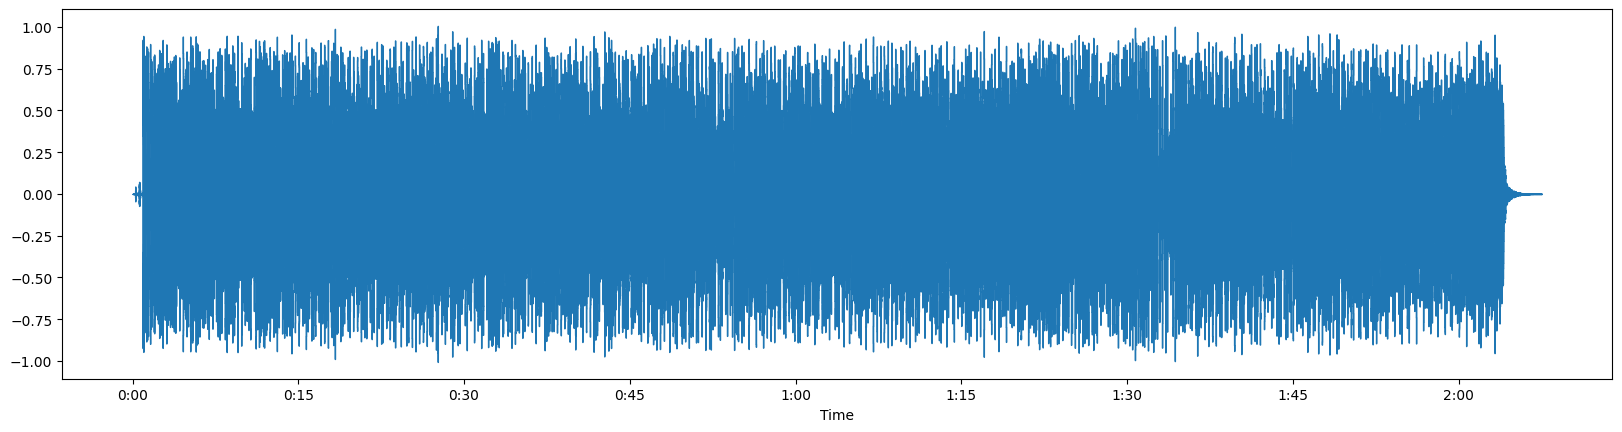

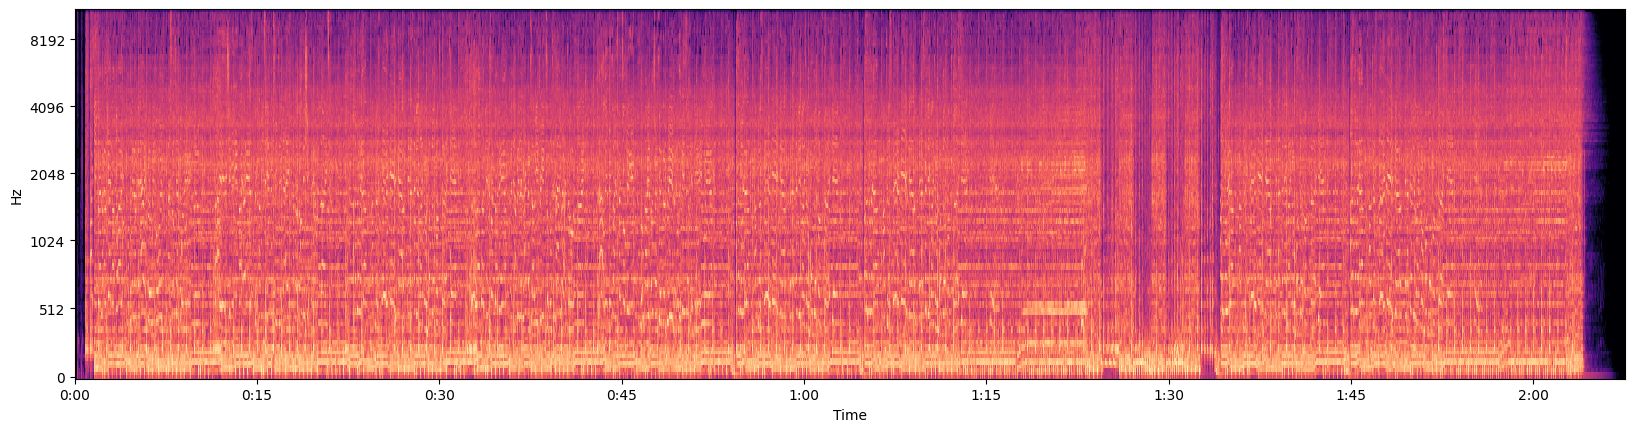

In [50]:
# @title Audioreactivity

structural_features = audio_structure_features

# @markdown ## 1. Choose a driving signal

import matplotlib.pyplot as plt
import keyframed as kf


# TODO: turn this into a drop down 

driving_signal_name = "default" #@param ['default','user specified','vocals stem','bass stem','other stem','drum stem']


# TODO: test this
custom_signal_fpath = '' # @param {'type':'string'}


#########################################

stems_path = root / "stems"
stems_outpath = stems_path / 'htdemucs_ft' / Path(storyboard.params.audio_fpath).stem
    
def ensure_stems_separated():    
    if not stems_outpath.exists():    
        !demucs -n htdemucs_ft -o {stems_path} "{storyboard.params.audio_fpath}"

def get_stem(instrument_name):
    ensure_stems_separated()
    stem_fpaths  = list(stems_outpath.glob('*.wav'))

    for stem_fpath in stem_fpaths:
        if instrument_name in str(stem_fpath):
            y, sr = librosa.load(stem_fpath)
            return y, sr
    raise ValueError(
        f"Unable to locate stem for instrument: {instrument_name}\n"
        f"in folder: {stems_outpath}"
    )

def get_user_specified_signal():
    y, sr = librosa.load(custom_signal_fpath)
    return y, sr

y = structural_features['y']
sr = structural_features['sr']

driving_signals = {
    'default': lambda: (y, sr),
    'user specified': get_user_specified_signal,
    'vocals stem':lambda: get_stem('vocals'),
    'bass stem':lambda: get_stem('bass'),
    'other stem':lambda: get_stem('other'),
    'drum stem':lambda: get_stem('drum'),
}


driving_signal, sr = driving_signals[driving_signal_name]()


display_signal(driving_signal, sr)

### Audio EQ cheat sheet

![Audio EQ cheat sheet](https://i.pinimg.com/736x/4f/28/5e/4f285e3fbc5b6b6ea78638e58b2e3052.jpg)

In [ ]:
# import numpy as np
# from scipy import signal
# #sig = np.repeat([0., 1., 0.], 100)
# # sig = normalized_signal

# # k=500
# # win_smooth = signal.windows.hann(int(k/4))#[k:]
# # win_decay = signal.windows.hann(2*k)
# # win_decay[:k]=0

# # #filtered = signal.convolve(sig, win, mode='same') / sum(win)
# # filtered = signal.convolve(sig, win_decay, mode='same') / sum(win_decay)
# # filtered = signal.convolve(filtered, win_smooth, mode='same') / sum(win_smooth)
# # filtered = signal.convolve(filtered, win_smooth, mode='same') / sum(win_smooth)
# # filtered = signal.convolve(filtered, win_smooth, mode='same') / sum(win_smooth)
# # filtered = signal.convolve(filtered, win_decay, mode='same') / sum(win_decay)

# # scipy.signal.find_peaks

# def smooth(y, k=150):
#     win_smooth = signal.windows.hann(k)
#     filtered = signal.convolve(y, win_smooth, mode='same') / sum(win_smooth)
#     return filtered

# def decay(y, k=500):
#     win_decay = signal.windows.hann(2*k)
#     win_decay[:k]=0
#     filtered = signal.convolve(y, win_decay, mode='same') / sum(win_decay)
#     return filtered



In [23]:
from inspect import signature
from functools import partial

#dir(signature(get_stem))
#signature(bandpass).parameters

#         filter_params = parse.parse("bandpass({low},{high})", manipulation)
#         low, high = float(filter_params['low']), float(filter_params['high'])
#         f = lambda y, sr: butter_bandpass_filter(y, sr, low, high)



signature(bandpass).parameters

mappingproxy({'low': <Parameter "low: float">,
              'high': <Parameter "high: float">})

In [36]:
bandpass.__name__

'bandpass'

In [37]:
[p for p in signature(bandpass).parameters]

['low', 'high']

functools.partial(<function butter_bandpass_filter at 0x7faf20e124d0>, low=array([-1.1256853e-05, -7.0239122e-07, -5.0764070e-06, ...,
        7.9458641e-06,  4.1685244e-06,  0.0000000e+00], dtype=float32), high=array(22050, dtype=uint32))

In [35]:
sig = signature(bandpass)
n_args = len(sig.parameters)
args = {k:v for k,v in zip(sig.parameters, (300,500))}
#sig.bind(args)
bandpass(**args)

functools.partial(<function butter_bandpass_filter at 0x7faf20e124d0>, low=300, high=500)

In [68]:
result = parse.parse("bandpass({low},{high})","bandpass(300,500)")
#dir(result)
result.named

{'low': '300', 'high': '500'}

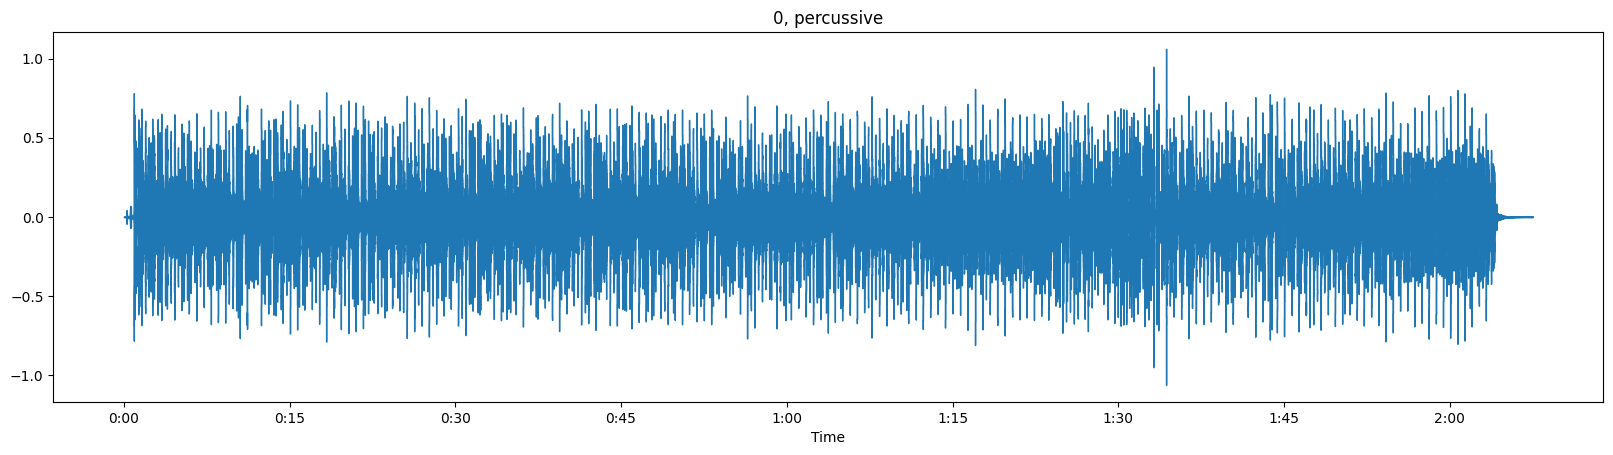

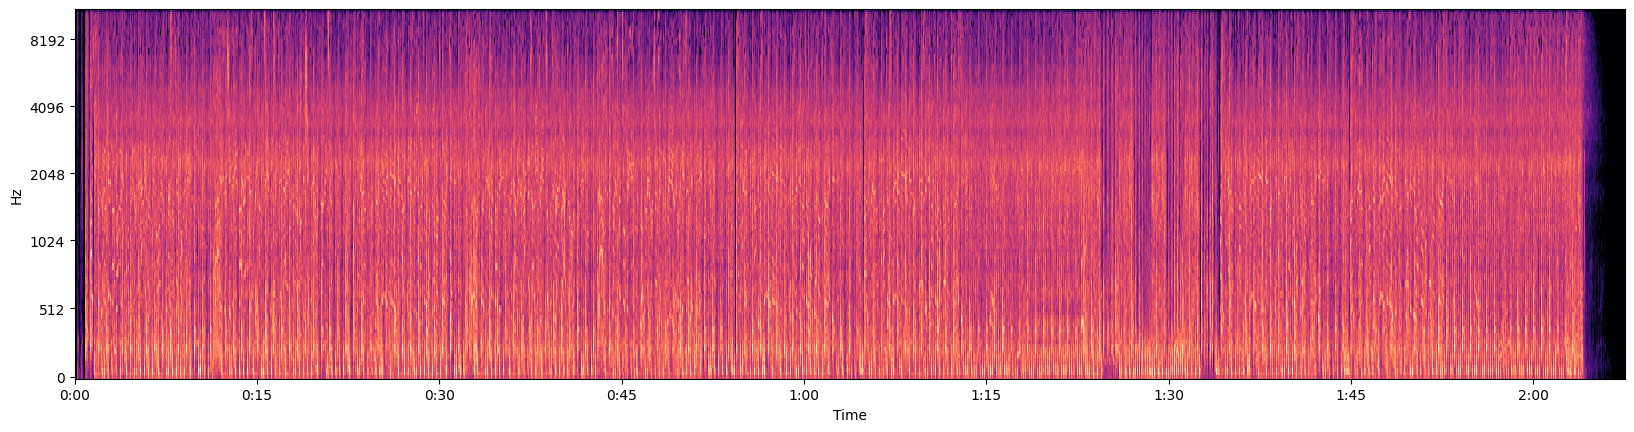

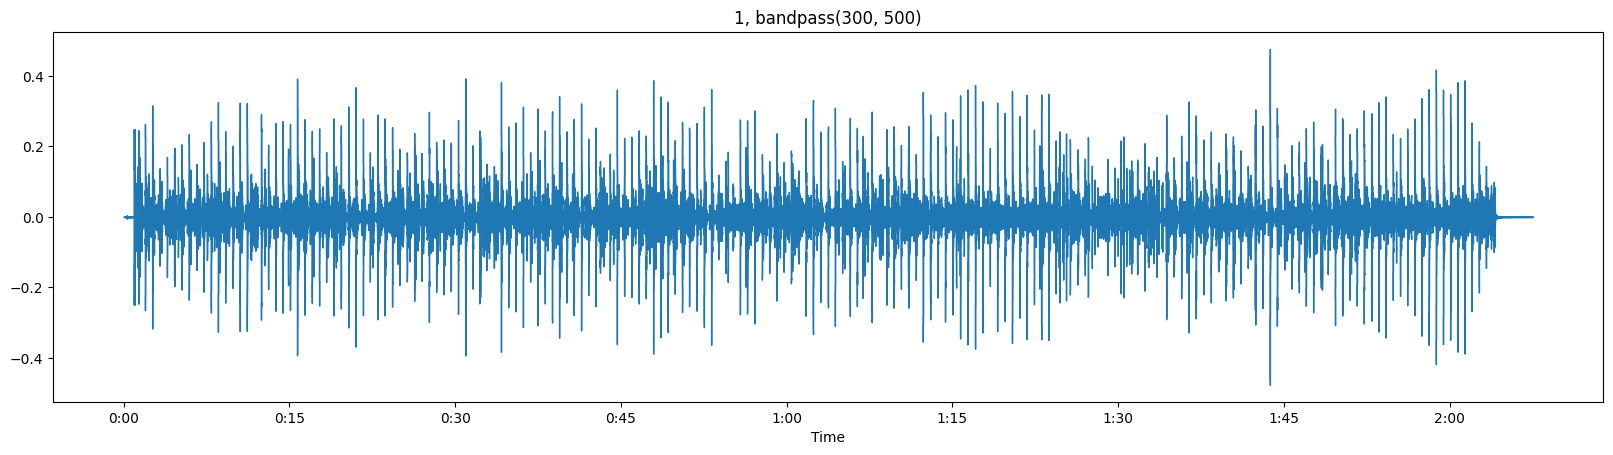

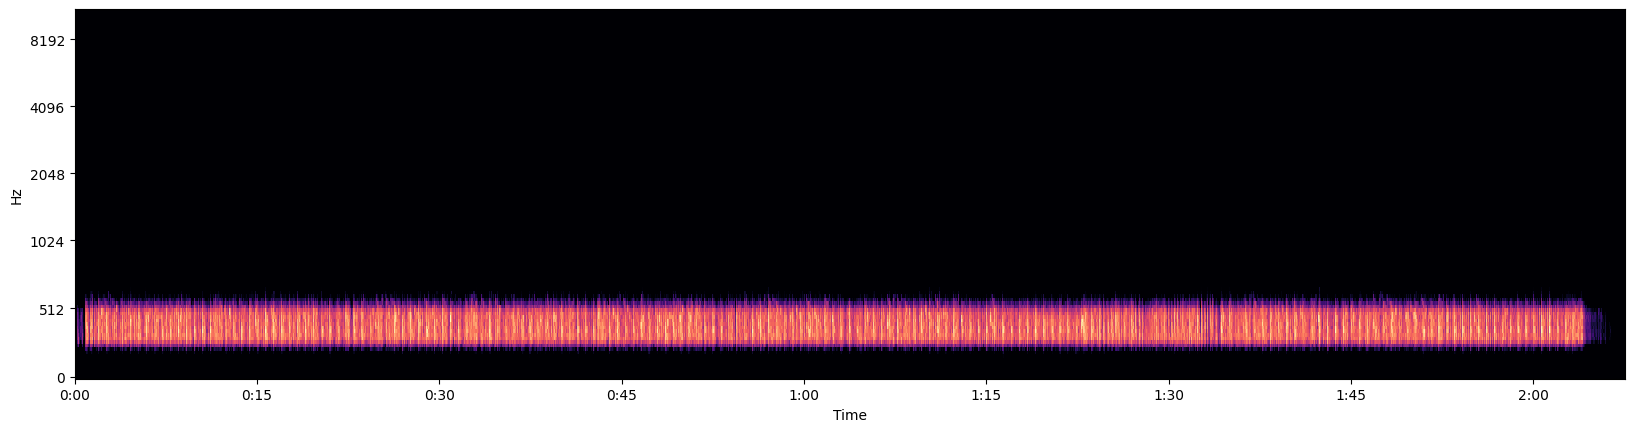

stretch() takes from 0 to 1 positional arguments but 2 were given


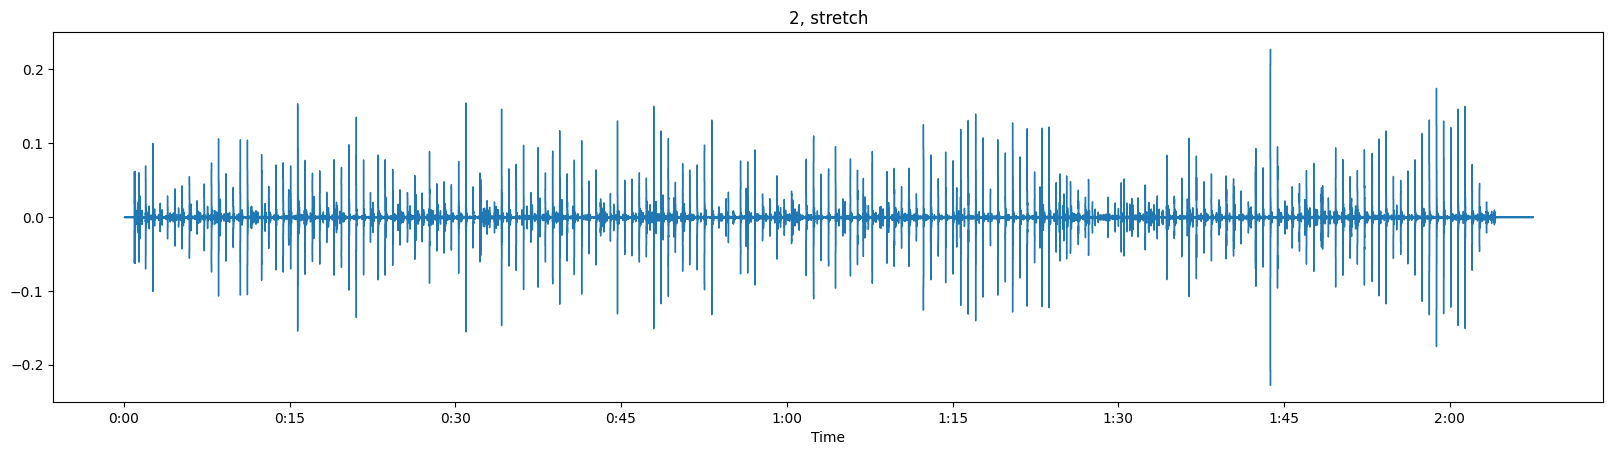

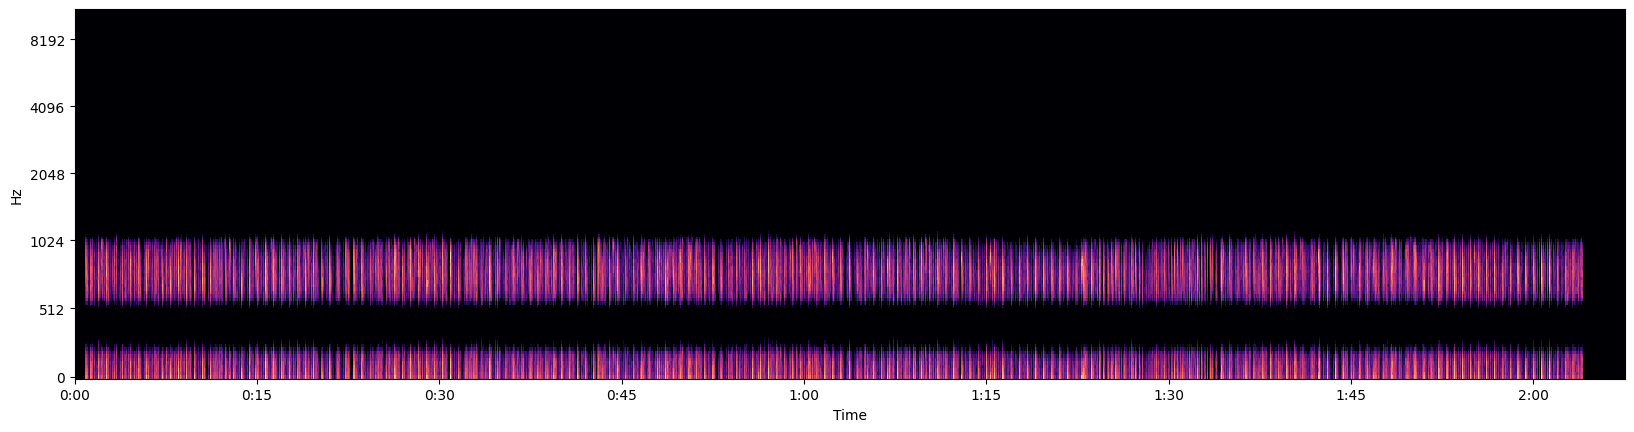

stretch() takes from 0 to 1 positional arguments but 2 were given


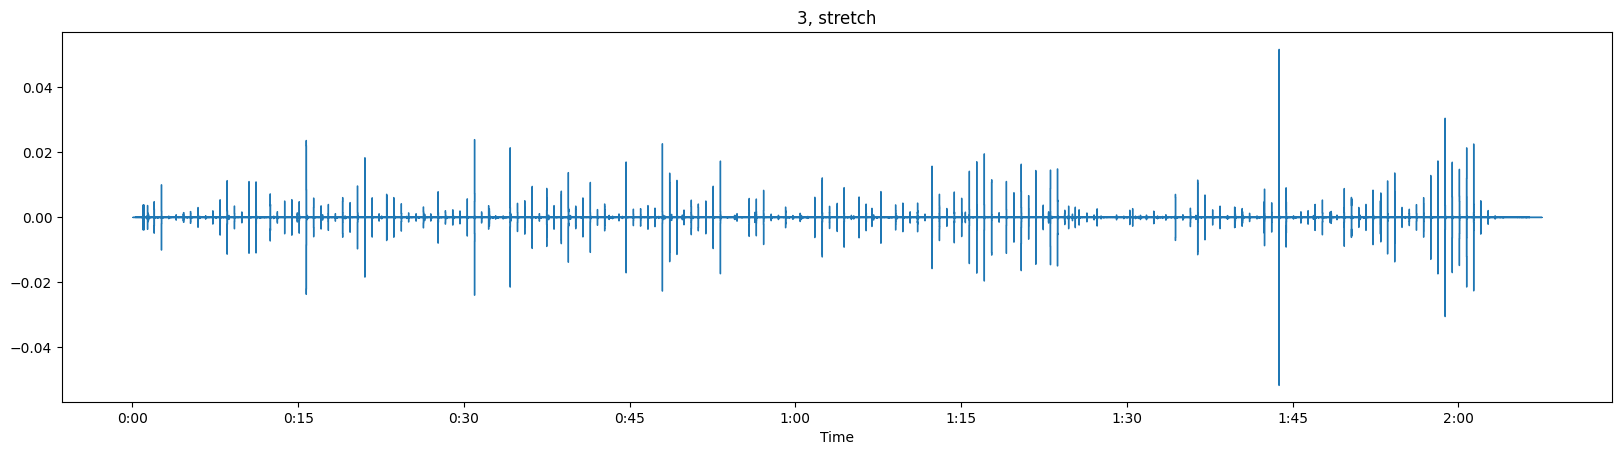

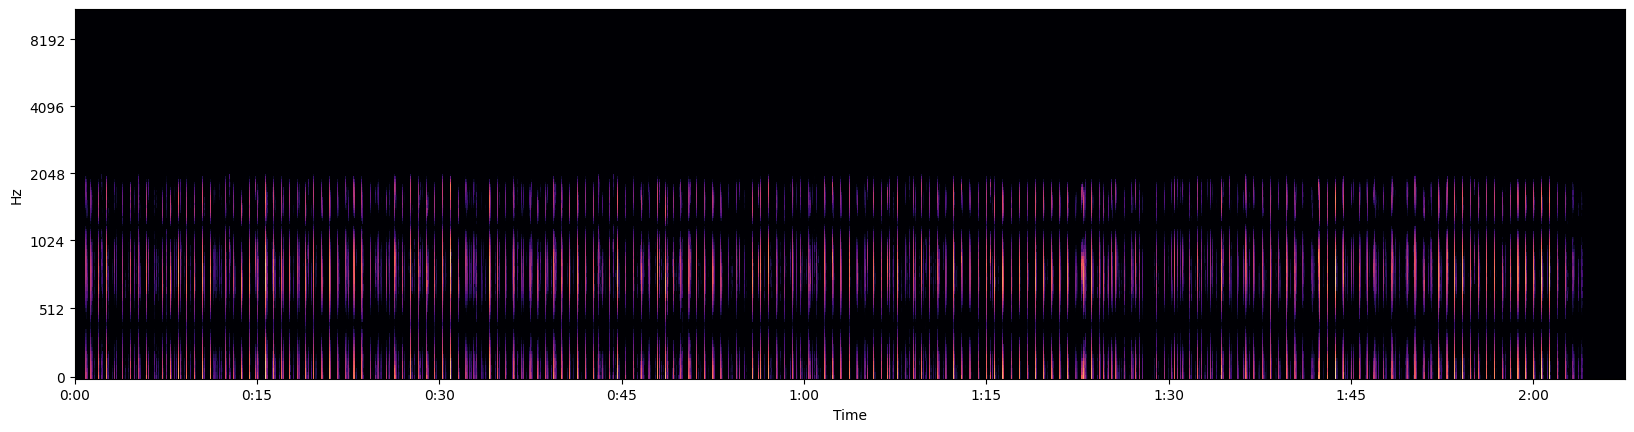

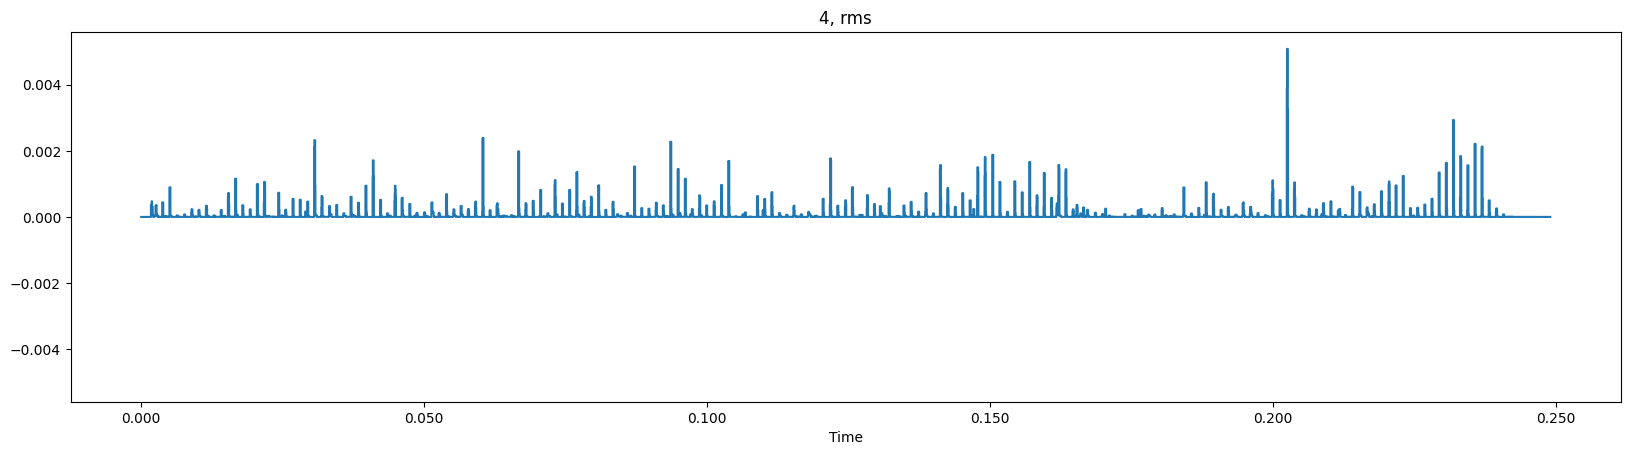

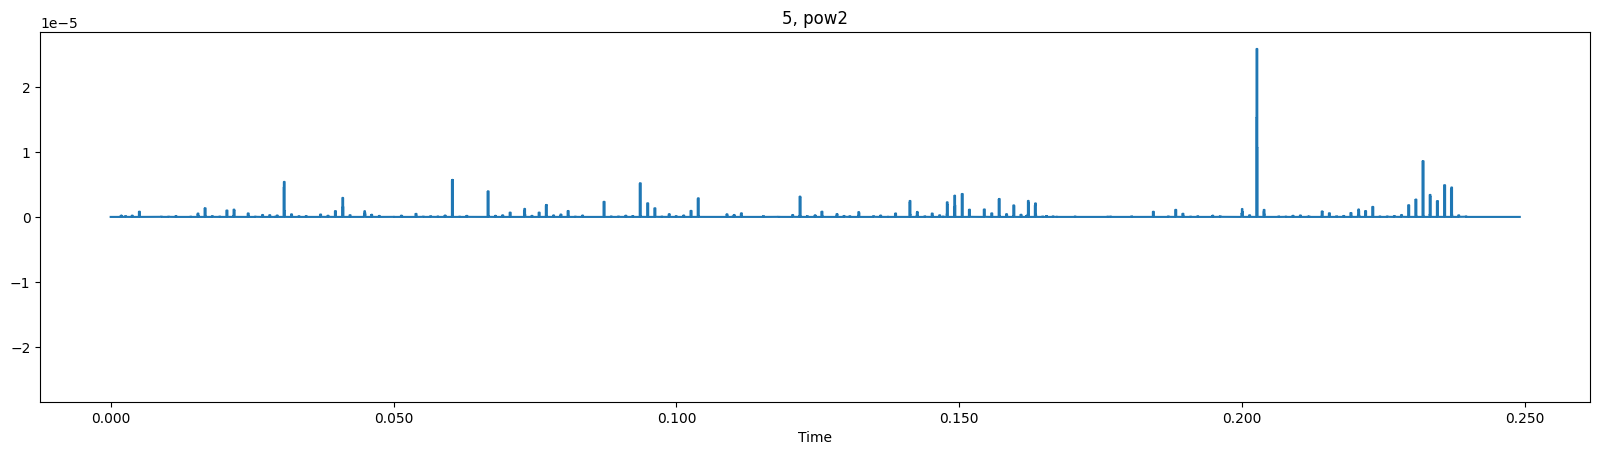

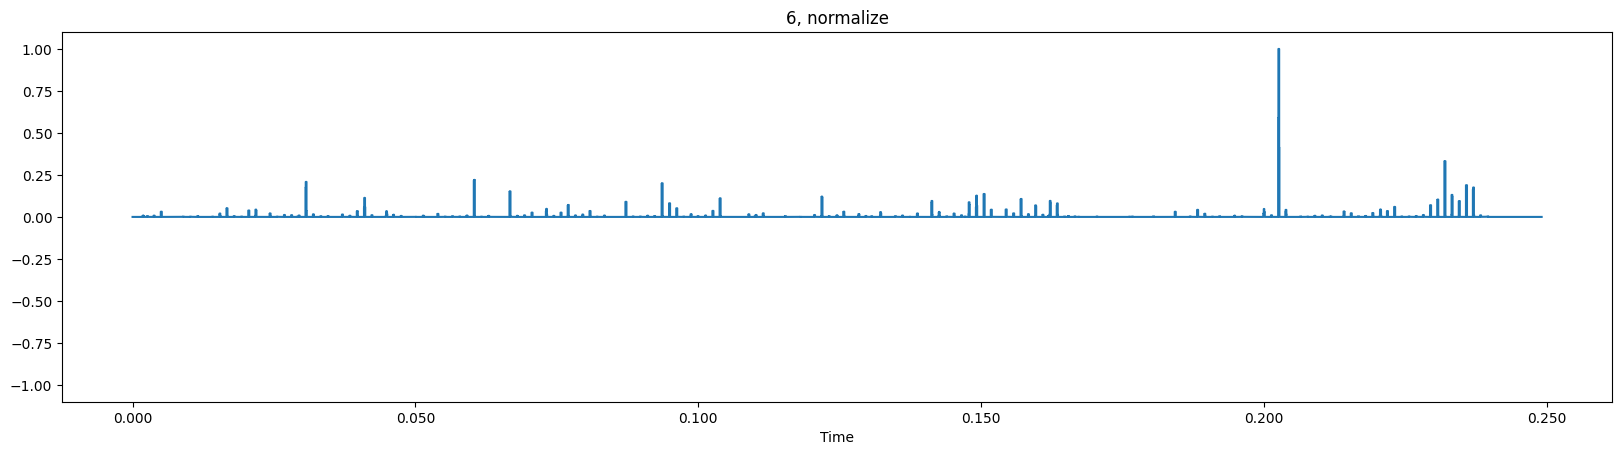

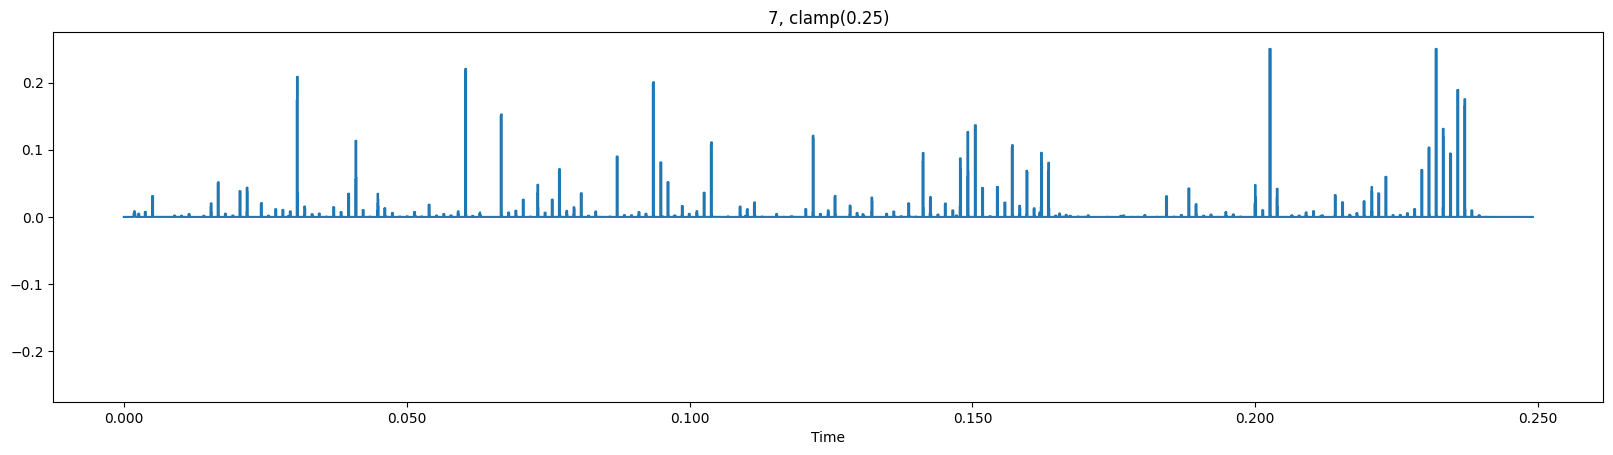

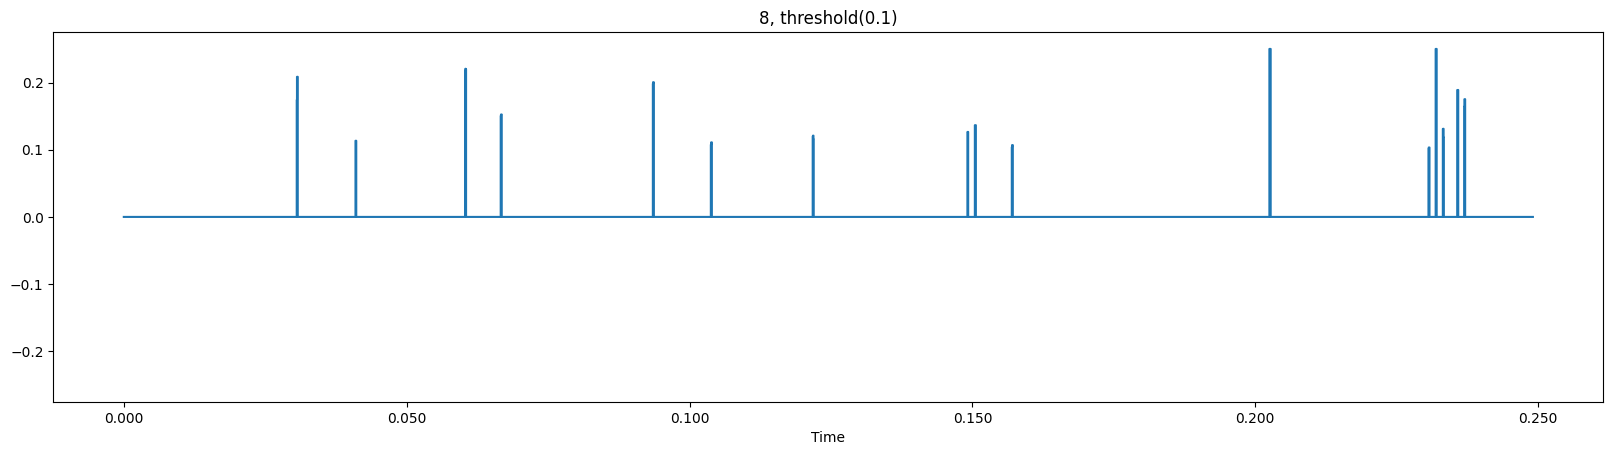

modulo() takes from 0 to 1 positional arguments but 2 were given


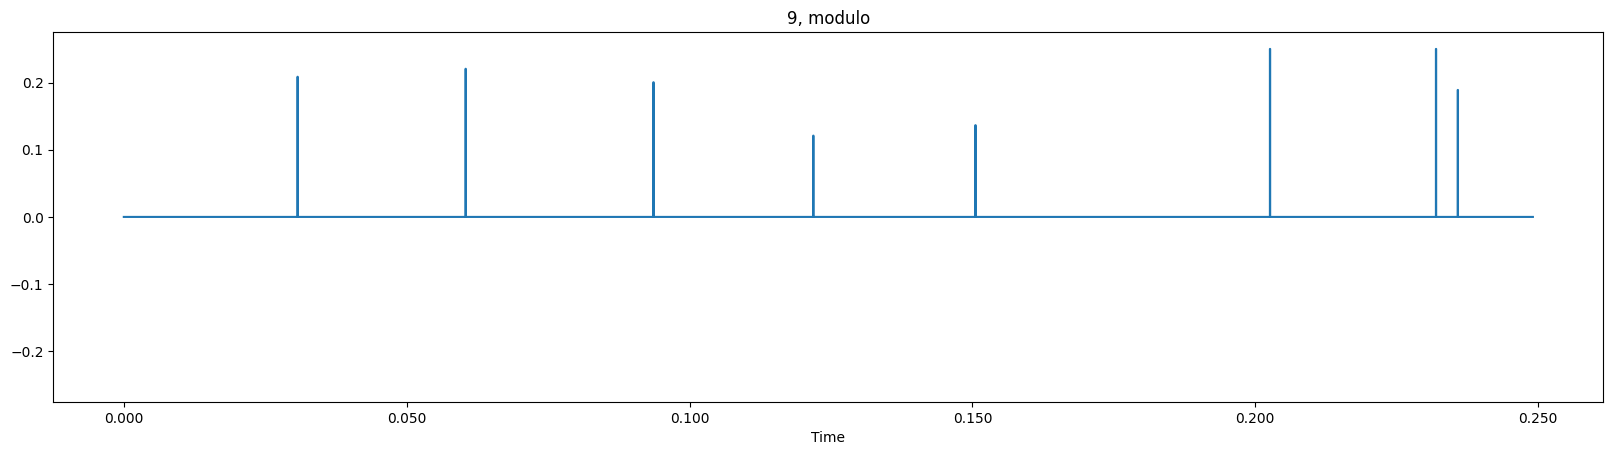

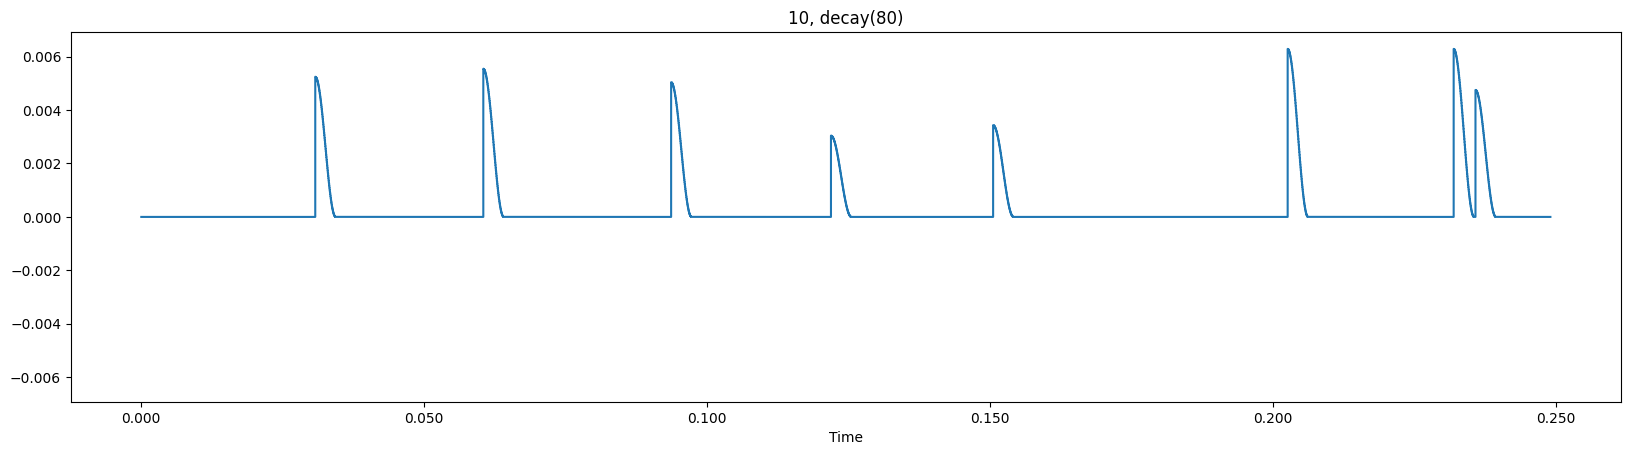

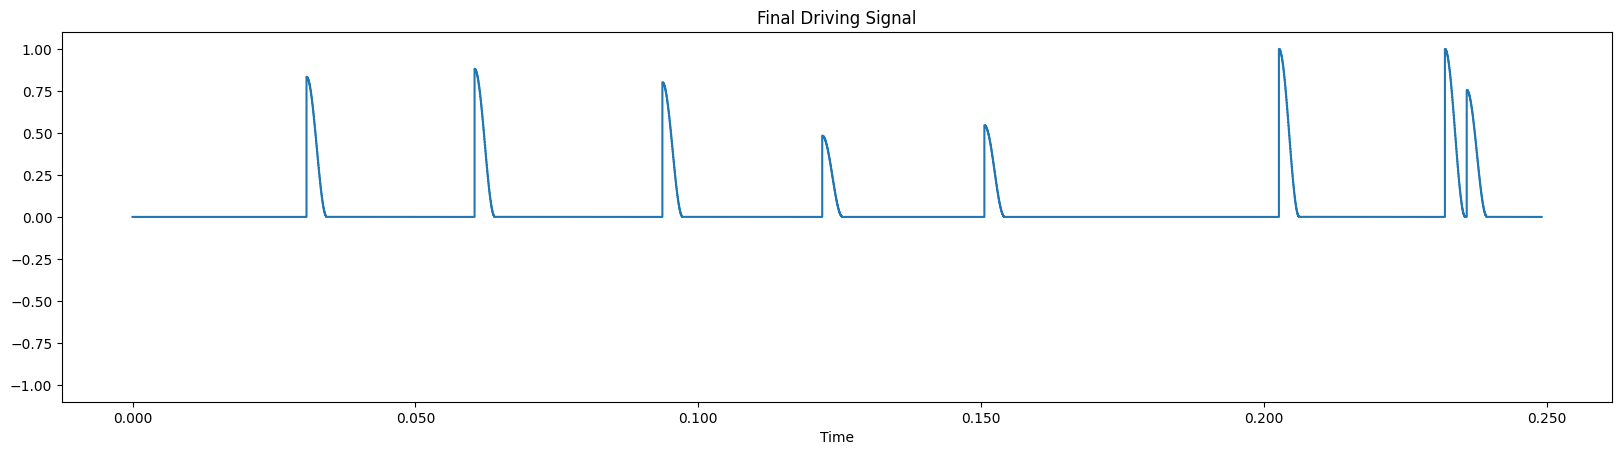

In [98]:
# @title 2. Manipulate the signal

# @markdown To apply multiple operations, separate manipulation names with a '|' or just re-run this cell.
# @markdown When you're satisfied, run the next cell to replace the loaded driving signal with the manipulated signal.

# @markdown #### Available Signal Manipulations
# @markdown * `raw` - no op
# @markdown * `rms` - Root mean squared. Converts raw signal to signal power
# @markdown * `novelty` - Estimates strength of sound event onsets.
# @markdown * `predominant_pulse` - Combined estimate of beat timing and strength

# @markdown * `pow2` - Square the signal. Increases gap between high and low amplitude signals
# @markdown * `stretch` - Alias for `pow2`

# @markdown * `sqrt` - Square root of signal. Reduces gap between high and low amplitude signals
# @markdown * `smoosh` - Alias for `sqrt`

# @markdown * `normalize` - Transform signal to `[0,1]` range. This will always be the last step, even if you don't specify it.
# @markdown * `smooth(k)` - Smoothes out the waveworm, using a smoothing window of `k`. Bigger `k` = flatter signal
# @markdown * `decay(k)` - Treats signal as a self-exciting process that decays over a window of `k`. 

# @markdown * `bandpass(low, high)` - Isolate signal to frequencies between `[low, high]`
# @markdown * `threshold(low)` - Zero the signal where amplitude is less than `low`
# @markdown * `clamp(high)` - Clamp the signal such that no values have amplitude greater than `high`

import numpy as np
from scipy import signal



# TODO: specify which transforms are available in spectral space vs. not


# trim/trim(q) -> y[y>quantile(y,.1)]
# round -> quantize
# that 4part way of parameterizing a wave... hit, sustain, decay,..?



# all operations must either have signature (y, sr) or return a function which does

def rms(y, sr):
    return librosa.feature.rms(y=y)

def novelty(y, sr):
    return librosa.onset.onset_strength(y, sr)

def predominant_pulse(y, sr):
    return librosa.beat.plp(y, sr)

def pow2(y, sr):
    return y**2

def sqrt(y, sr):
    return y**-2


# so... apparently `pow` is a python builtin. whoops. Meh, fuck it.
def _pow(k):
    def pow_(y, sr):
        return y**k
    return pow_

def stretch(k=2):
    return _pow(k)

def smoosh(k=2):
    return _pow(-k)

def normalize(y, sr):
    normalized_signal = np.abs(y).ravel()
    normalized_signal /= max(normalized_signal)
    return normalized_signal
    
######################################
    
def smooth(k=150):
    k=int(k)
    def smooth_(y, sr=None):
        win_smooth = signal.windows.hann(k)
        filtered = signal.convolve(y, win_smooth, mode='same') / sum(win_smooth)
        return filtered
    return smooth_

def decay(k=500):
    k=int(k)
    def decay_(y, sr=None):
        win_decay = signal.windows.hann(2*k)
        win_decay[:k]=0
        filtered = signal.convolve(y.ravel(), win_decay, mode='same') / sum(win_decay)
        return filtered
    return decay_


#####################333
    
def bandpass(low: float, high:float):
    # low = float(low)
    # high=float(high)
    return partial(butter_bandpass_filter, lowcut=low, highcut=high)
    
def threshold(low):
    def f(y, sr):
        y[y<low] = 0
        return y
    return f

def clamp(high):
    def f(y, sr):
        y[y>high] = high
        return y
    return f
    
def just_harmonic(y, sr):
    harmonic, percussive = librosa.effects.hpss(y)
    return harmonic

def just_percussive(y, sr):
    harmonic, percussive = librosa.effects.hpss(y)
    return percussive 


###############################3


from scipy.signal import find_peaks

# def peak_detection(y, sr):
#     peaks, _ = find_peaks(y)
#     return peaks

def modulo(k=2):
    def modulo_(y, sr=None):
        #peaks = peak_detection(y, sr)
        peaks, _ = find_peaks(y)
        selected_peaks = peaks[::k]  # Select every kth peak
        new_signal = np.zeros_like(y)
        new_signal[selected_peaks] = y[selected_peaks]  # Build a new signal with only the selected peaks
        return new_signal
    return modulo_

#################################


# # TODO: add operations: threshold(val), clamp(val), quantize(n)
simple_signal_operations = {
    'raw': lambda y, _: y,
    ##########
    'rms': lambda y, _: librosa.feature.rms(y=y),
    'novelty': librosa.onset.onset_strength,
    'predominant_pulse': librosa.beat.plp,
    'bandpass': bandpass,
    'harmonic': lambda y, _: librosa.effects.harmonic(y=y),
    'percussive': lambda y, _: librosa.effects.percussive(y=y),
    ##########
    'pow2': lambda y, _: y**2,
    'stretch': stretch,
    'sqrt': sqrt,
    'smoosh': smoosh,
    'pow':_pow,
    #################
    'smooth': smooth,
    'decay': decay,
    # #########
    'normalize': normalize,
    'abs': lambda y, _ : np.abs(np.abs(y)), 
    'threshold': threshold,
    'clamp': clamp,
    'modulo': modulo,
}

def prepare_operation(op_str, operations=simple_signal_operations):
    op_str = op_str.replace(' ','') # make sure there are no spaces separating arguments
    for op_name, op in operations.items():
        if op_name == op_str:
            return op
        
    # if we're here, that should mean we have arguments to parse.
    for op_name, op in operations.items():
        if op_str.startswith(f"{op_name}("):
            break
    else: # if we're here, it means we never broke out of the `for` loop, i.e. couldn't find a matching op
        raise ValueError(f"{op_str} is not a supported operation. Supported operations: {[op_name for op in operations]}")
    
    arg_names = [p for p in signature(op).parameters]
    bracketed = ["{" + p + "}" for p in arg_names]
    template = f"{op_name}({','.join(bracketed)})"
    result = parse.parse(template, op_str)
    kargs = result.named
    kargs = {k:float(v) for k,v in kargs.items()} # coerce strings to floats
    return op(**kargs)
    

# signal_manipulations = 'bandpass(300, 500) | pow2 | pow2 | rms | pow2 | threshold(5e-6) ' # @param {'type':'string'}
signal_manipulations = 'percussive | bandpass(300, 500) | stretch | stretch | rms | pow2 | normalize | clamp(0.25) |  threshold(0.1) | modulo | decay(80) '

manipulations = [m.strip() for m in signal_manipulations.split('|') if m.strip()]

# reset processing
driving_signal_massaged = driving_signal


show_spec=True
for idx, manipulation in enumerate(manipulations):

    f = prepare_operation(manipulation)
    try:
        driving_signal_massaged = f(driving_signal_massaged, sr)
    except TypeError as e: # this is sort of gross but fuck it
        print(e)
        f=f()
        driving_signal_massaged = f(driving_signal_massaged, sr)
    
    # visualize
    if manipulation in ('rms'):
        show_spec=False
    display_signal(driving_signal_massaged, sr, title=f"{idx}, {manipulation}", show_spec=show_spec)
else:
    # finalize signal
    driving_signal_massaged = np.abs(driving_signal_massaged).ravel()
    driving_signal_massaged /= max(driving_signal_massaged)
    display_signal(driving_signal_massaged, sr, title=f"Final Driving Signal", show_spec=False)


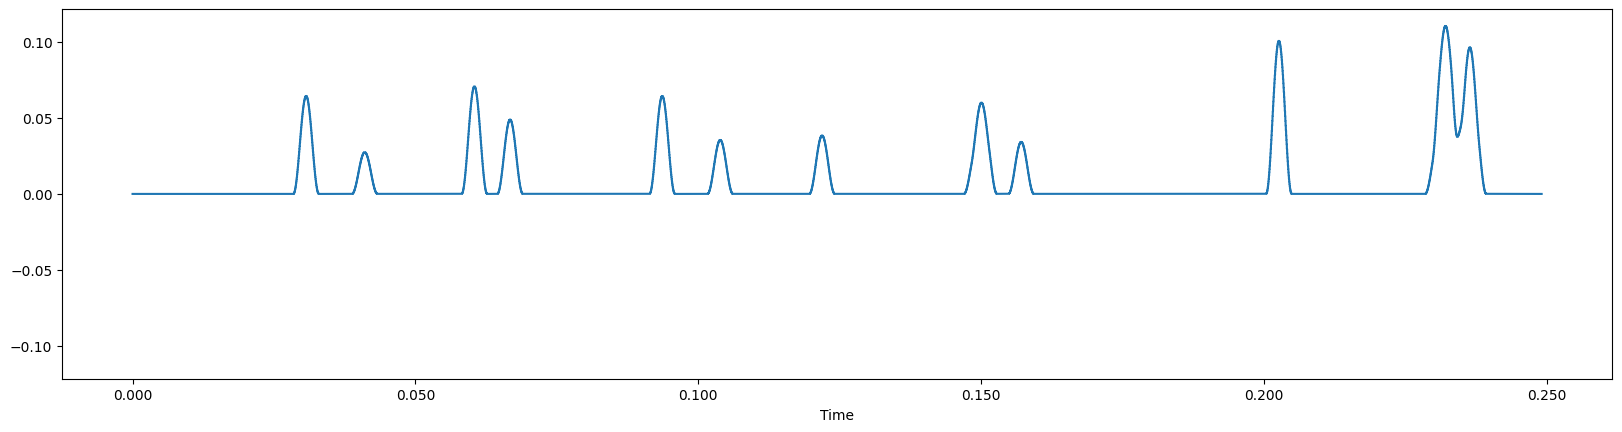

In [93]:
display_signal(smooth(100)(y=driving_signal_massaged, sr=sr), sr, show_spec=False)

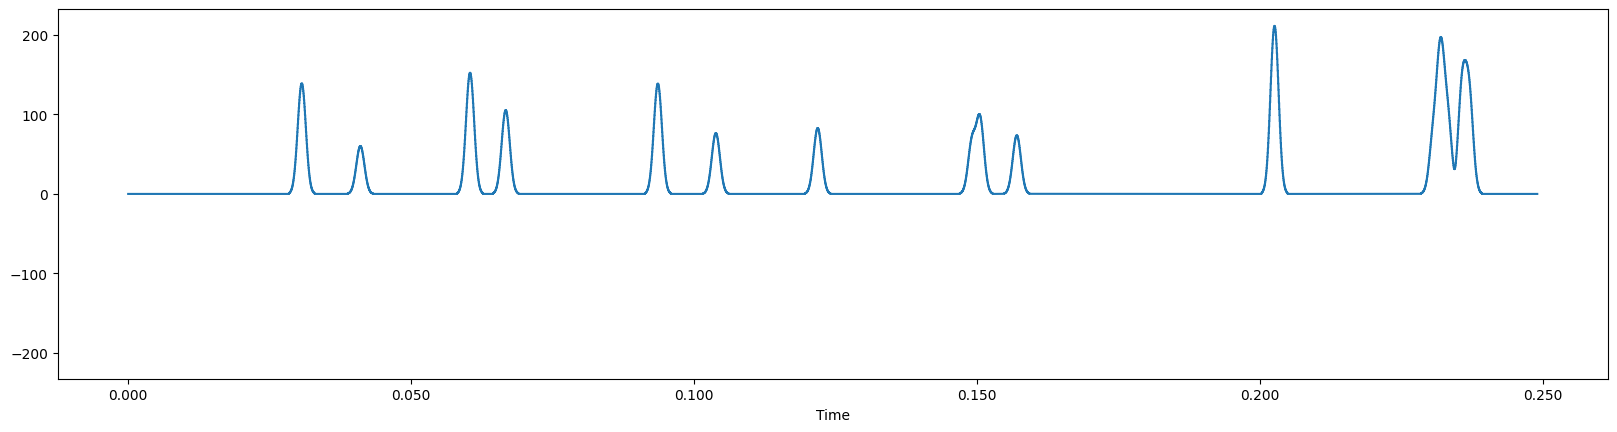

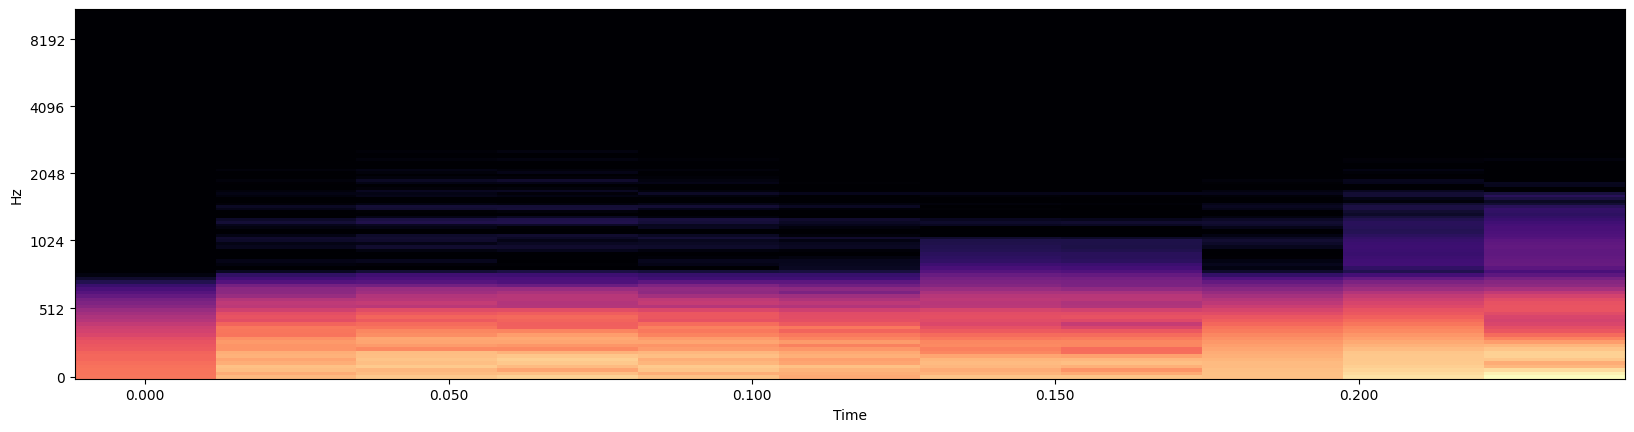

In [94]:
M = 100
s = 4.0
w = 0.5
wavelet = signal.morlet(M, s, w)
filtered = signal.convolve(driving_signal_massaged, wavelet, mode='same') / sum(wavelet)
display_signal(np.abs(filtered).ravel(), sr=sr)

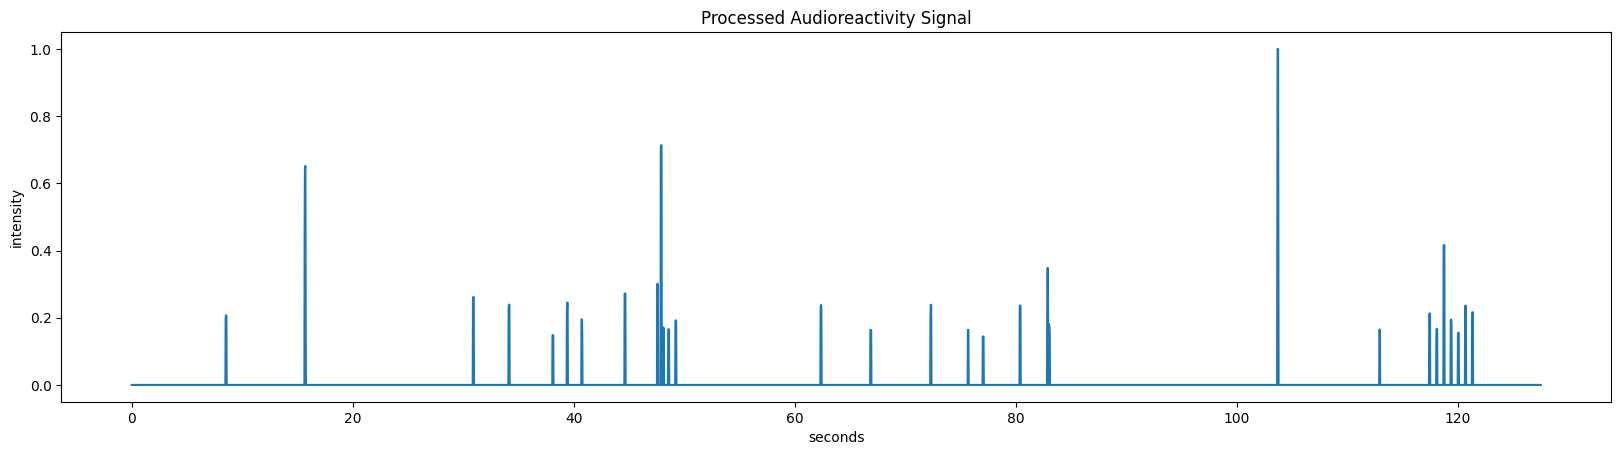

In [64]:
# @title 2b. Run this cell when you're satisfied with the transformed signal

use_massaged_signal = True # @param {'type':'boolean'}
if use_massaged_signal:
    driving_signal = driving_signal_massaged


### Uncomment this snippet to write your driving signal to an audio file
#import soundfile
#soundfile.write('driving_signal.wav', driving_signal, sr)

normalized_signal = np.abs(driving_signal).ravel()
normalized_signal /= max(normalized_signal)

frame_time = librosa.frames_to_time(np.arange(len(normalized_signal)), sr=sr)

driving_signal_kf = kf.Curve({t:v for t,v in zip(frame_time, normalized_signal)})

plt.plot(frame_time, normalized_signal)
plt.xlabel('seconds')
plt.ylabel('intensity')
plt.title("Processed Audioreactivity Signal")
full_width_plot()

(array([16., 24., 14.,  6.,  9., 21.,  4.,  5.,  0.,  3.,  1.,  1.,  0.,
         0.,  0.,  5.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  3.,  0.,  0.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([0.14407542, 0.16119392, 0.17831241, 0.1954309 , 0.21254939,
        0.22966789, 0.24678637, 0.26390487, 0.28102335, 0.29814184,
        0.31526035, 0.33237883, 0.34949732, 0.3666158 , 0.38373432,
        0.4008528 , 0.41797128, 0.43508977, 0.45220828, 0.46932676,
        0.48644525, 0.50356376, 0.52068222, 0.53780073, 0.55491924,
        0.5720377 , 0.58915621, 0.60627472, 0.62339318, 0.64051169,
        0.65763015, 0.67474866, 0.69186717, 0.70898563, 0.72610414,
        0.74322265, 0.76034111, 0.77745962, 0.79457808, 0.81169659,
        0.8288151 , 0.84593356, 0.86305207, 0.88017058, 0.89728904,
        0.91440755, 0.93152601, 0.94864452, 0.96576303, 0.98288149,
        1.        ]),
 <BarContainer

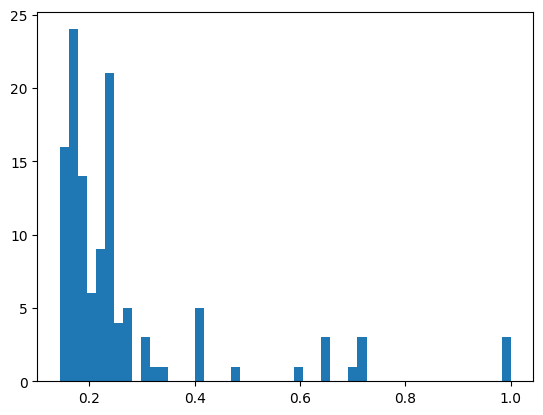

In [71]:
plt.hist(normalized_signal[normalized_signal>0], bins=50)

In [111]:
import numpy as np
from scipy import signal
#sig = np.repeat([0., 1., 0.], 100)
sig = normalized_signal

k=500
win_smooth = signal.windows.hann(int(k/4))#[k:]
win_decay = signal.windows.hann(2*k)
win_decay[:k]=0

#filtered = signal.convolve(sig, win, mode='same') / sum(win)
filtered = signal.convolve(sig, win_decay, mode='same') / sum(win_decay)
filtered = signal.convolve(filtered, win_smooth, mode='same') / sum(win_smooth)
filtered = signal.convolve(filtered, win_smooth, mode='same') / sum(win_smooth)
filtered = signal.convolve(filtered, win_smooth, mode='same') / sum(win_smooth)
filtered = signal.convolve(filtered, win_decay, mode='same') / sum(win_decay)

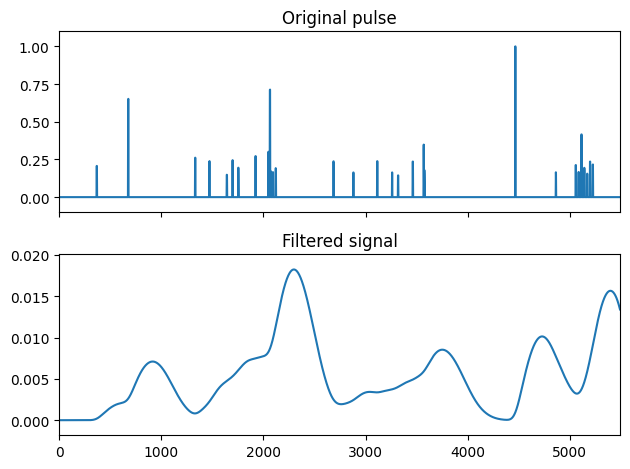

In [112]:
import matplotlib.pyplot as plt
#fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
fig, (ax_orig,  ax_filt) = plt.subplots(2, 1, sharex=True)

ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
# ax_win.plot(win)
# ax_win.set_title('Filter impulse response')
# ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()

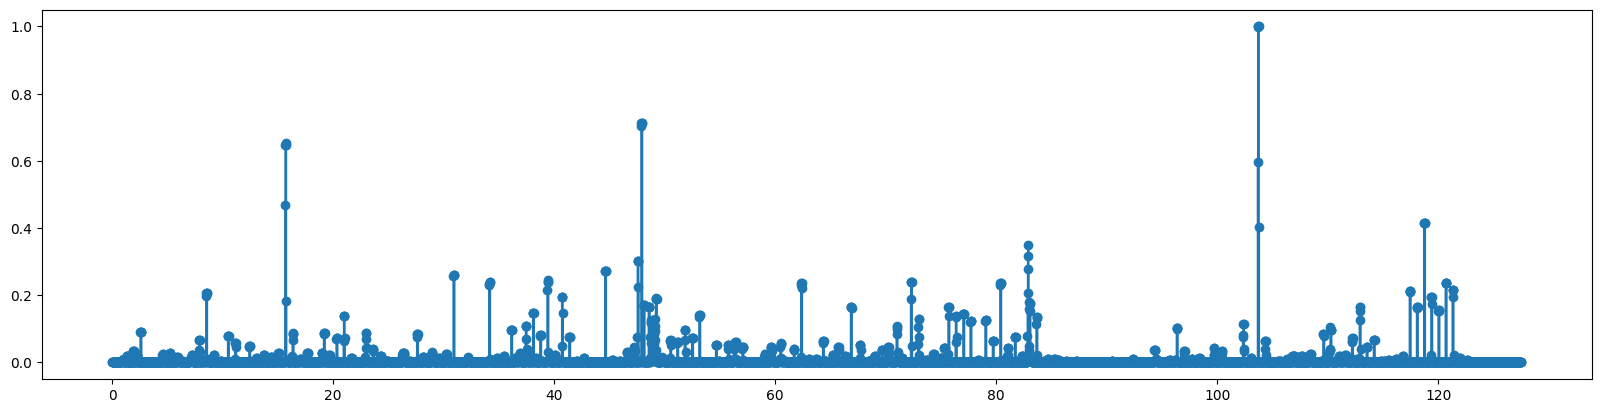

In [27]:

driving_signal_kf.plot()
full_width_plot()

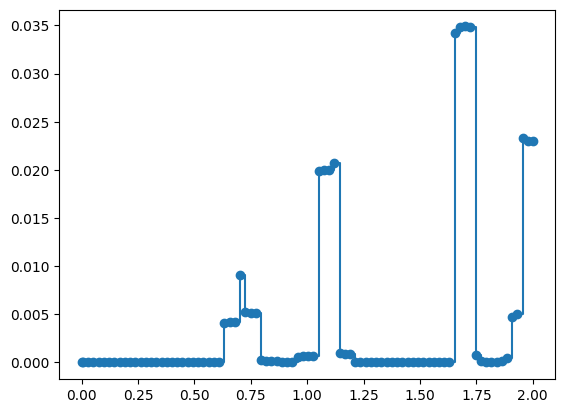

In [53]:
from scipy.interpolate import interp1d
from keyframed import Curve
from keyframed.interpolation import get_context_left, get_context_right, register_interpolation_method

def user_defined_quadratic_interp(k, curve, n=2):
    xs = get_context_left(k, curve, n)
    xs += get_context_right(k, curve, n)
    ys = [curve[x] for x in xs]
    f = interp1d(xs, ys, kind='quadratic')
    return f(k)

register_interpolation_method('quadratic', user_defined_quadratic_interp)

# sample some random points that are linearly correlated with some jitter
#d = {i:i+2*random.random() for i in range(10)}
#curve = Curve(d, default_interpolation=user_defined_quadratic_interp)

#xs = np.linspace(0,9,100)
#curve.plot(xs=xs)

def curve_from_signal(
    y,
    name = 'strength',
    hi= 1,
    low = 0,
    inverse_relationship = False,
    sr=22050,
):
    # normalize signal
    y = np.abs(y).ravel()
    y /= max(y)
    if inverse_relationship:
        y = 1 - y
    y = y*(hi-low) + low
    
    frame_time = librosa.frames_to_time(np.arange(len(y)), sr=sr)
    return Curve({t:v for t,v in zip(frame_time, y)}, label=name) #, default_interpolation='quadratic') # interp method makes basically zero difference given high SR

curve = curve_from_signal(driving_signal)
curve[0.25:2.25].plot()

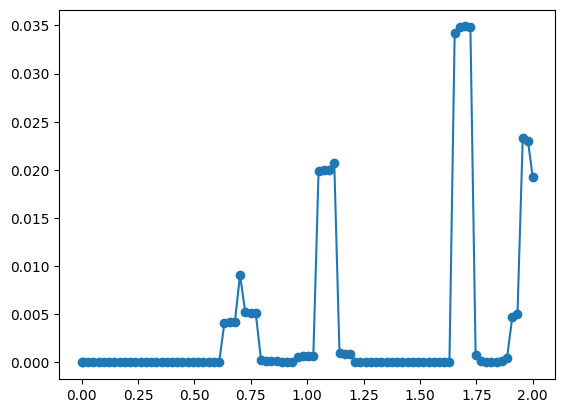

In [51]:
curve[0.25:2.25].plot()

In [55]:
# to do:
# * thresholding
# * exp decay 
# * smoothing

In [25]:
# @title 3a. Map the driving signal to parameter ranges 

#TODO: Build these curves/signals agnostic of VKTRS's scene abstraction

signals =[
    dict(
        signal_name = 'noise_reactive',
        attr_hi= .08,
        attr_low = .02,
        inverse_relationship = False,
    ),
    dict(
        attr_hi=.7,
        attr_low = .3,
        inverse_relationship = True,
        signal_name =  'audio_reactive_curve',
    ),
]


# 3b. Map the driving signal to parameter ranges
reactive_signal_map = {
    'audio_reactive_curve':'strength_curve',
    'noise_reactive':'noise_add_curve',
}

# TODO: make the above part more user friendly


##################################################################################################################
##################################################################################################################

# Hi user. You've gone to far. Don't worry about this stuff. Just the bit above the line.

for signal_params in signals:

    attr_hi= signal_params['attr_hi']
    attr_low = signal_params['attr_low']
    inverse_relationship = signal_params['inverse_relationship']
    signal_name = signal_params['signal_name']

    # TODO: instead of attaching the string, let's just build a curve object and use
    #       keyframed.Curve's native serialization. this was the whole point of doing it that way.

    #print(signal_params)

    
#     for scene_idx, rec in enumerate(storyboard.prompt_starts):
#         #print(scene_idx)
#         if scene_idx == 0:
#             prev_rec = rec
#             continue
#         start, end = prev_rec['start'], rec['start']
#         if prev_rec['frames'] < 1:
#             continue
            
#         curve_chunks = []        
#         for frame_idx in range(prev_rec['frames']):
#             curr_time = start + frame_idx * ifps
#             signal_value = driving_signal_kf[curr_time]
#             if inverse_relationship:
#                 signal_value = 1-signal_value
#             attr_value = signal_value*(attr_hi-attr_low)+attr_low
#             curve_chunks.append(f"{frame_idx}:({attr_value})")
#         curve_str = ','.join(curve_chunks)
#         prev_rec[signal_name] = curve_str
#         prev_rec = rec
#     else: # hate this.
#         start, end = rec['start'], rec['end']
#         if rec['frames'] > 0:
#             curve_chunks = []
#             for frame_idx in range(rec['frames']):
#                 curr_time = start + frame_idx * ifps
#                 signal_value = driving_signal_kf[curr_time]
#                 if inverse_relationship:
#                     signal_value = 1-signal_value
#                 attr_value = signal_value*(attr_hi-attr_low)+attr_low
#                 curve_chunks.append(f"{frame_idx}:({attr_value})")
#             curve_str = ','.join(curve_chunks)
#             rec[signal_name] = curve_str

            


# TODO: save keyframed objects for signals

if not storyboard.get('audioreactive'):
    storyboard.audioreactive = {'signals': [], 'reactive_signal_map': {}}

# TODO: check if these signals are already in the board
#       ...actually, will probably be simpler to just reshape this so each signal is a dict whose key is the name
storyboard.audioreactive.signals.append(signals) 

storyboard.audioreactive.reactive_signal_map.update(reactive_signal_map)
save_storyboard(storyboard)

In [38]:

    
def kf_to_cn_string(curve):
    return ','.join(
        [f"{kf['t']}:({kf['value']})" 
         for kf in curve.to_dict()['curve'].values()
        ])

kf_to_cn_string(driving_signal_kf)

'0.0:(2.3165826765019464e-36),0.023219954648526078:(8.415951230740316e-36),0.046439909297052155:(2.2245132868146778e-35),0.06965986394557823:(2.5665992185665303e-35),0.09287981859410431:(2.3671404130243245e-35),0.11609977324263039:(2.432546657838785e-35),0.13931972789115646:(1.6867442798493775e-35),0.16253968253968254:(1.3969608155539422e-35),0.18575963718820862:(5.169542638125331e-27),0.2089795918367347:(1.8278814871407182e-19),0.23219954648526078:(2.682067292626433e-17),0.25541950113378686:(3.065770901626916e-17),0.2786394557823129:(8.228886701395105e-17),0.301859410430839:(8.284818007437981e-17),0.3250793650793651:(5.621485032196894e-17),0.34829931972789113:(5.2377873788968213e-17),0.37151927437641724:(7.46719358502711e-19),0.3947392290249433:(4.615263113468854e-21),0.4179591836734694:(7.140360599656056e-23),0.44117913832199546:(1.411467039638416e-22),0.46439909297052157:(8.468523549049899e-22),0.4876190476190476:(8.933236585823549e-22),0.5108390022675737:(8.911738169781231e-22),0.5